<a href="https://colab.research.google.com/github/cawoylel/nlp4all/blob/main/asr_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---

<h1 align="center"><strong>NLP4ALL ASR Tutorial: Seerer Language</strong></h1>

<h4 align="center"><strong>Yaya Sy</strong></h4>

---

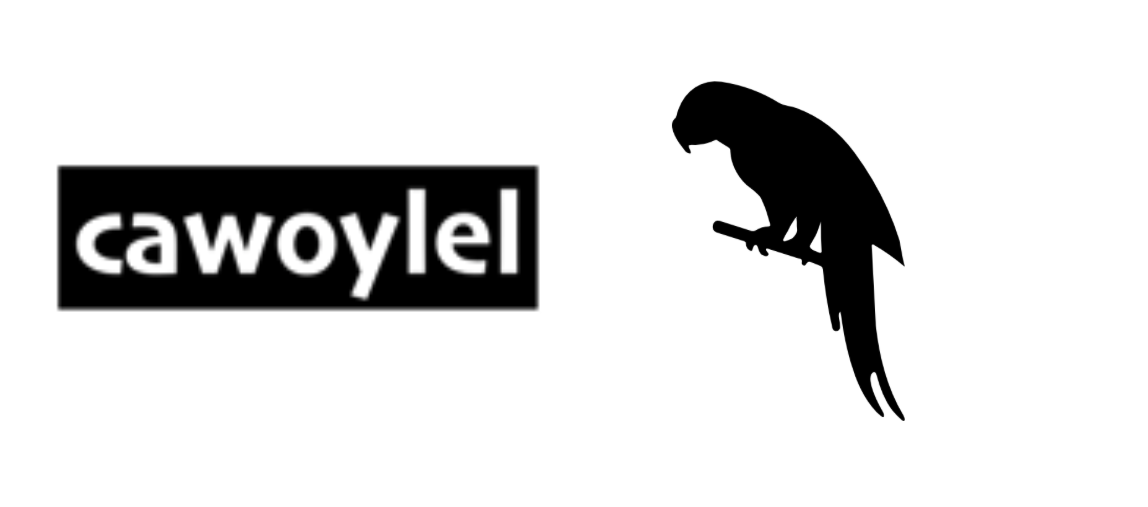

# Introduction

Welcome to our latest adventure at Cawoylel! If you’ve been following us, you know we hold a visionary perspective that embraces the powerful role of technology in **preserving and promoting linguistic and cultural diversity**. **Our journey began with Fula**, where we developed **Windanam**, the first Fula multidialectal speech recognition model. But our mission extends far beyond a single language. We believe in open-source, collaborative approaches that can democratize AI for all of Africa. The recent success with Windanam sparked a question: *can other African languages follow suit?*

We're a glad to introduce the **NLP4ALL** ASR tutorial, a detailed guide developed by our **NLP Lead** and **Co-Founder - Yaya Sy**, to empower communities to create speech recognition solutions for their languages! This step-by-step guide equips you with the knowledge to develop your own ASR solution. By using **Seerer**, a language spoken in Senegal, as a case study, we aim to provide a replicable approach that can be adapted to any African language. Our goal is to make this technology accessible, offering a template that communities can use to ensure their language thrive in the digital age.

In this tutorial, we break down the entire process, from data collection (using the Bible as an example) to model creation. We'll cover *audio segmentation*, *transcription alignment*, *data preparation* with Hugging Face 🤗, and finally, building your ASR model by *fine-tuning an existing open-source model*.

# Table of Contents

1. [Setup and Configuration](#setup-and-configuration)
2. [Getting the ASR Data](#data-collection)
    - 2.1 [Bible Crawler](#bible-crawler)
    - 2.2 [Resampling the Audios](#resampling-the-audios)
    - 2.3 [Neural Forced Alignment](#neural-forced-alignment)
3. [Data Preprocessing](#data-preprocessing)
    - 3.1 [Preparing the HuggingFace Dataset](#preparing-the-huggingface-dataset)
    - 3.2 [Preprocessing the Dataset](#preprocessing-the-dataset)
4. [Fine-Tuning Whisper Large on Seereer ASR Dataset](#finetuning)
    - 4.1 [Load Model](#load-model)
    - 4.2 [Prepare the Pretrained Model for LoRA](#prepare-the-pretrained-model-for-lora)
    - 4.3 [Attach Adapters to the Pretrained Model](#attach-adapters-to-the-pretrained-model)
    - 4.4 [Data Loader](#data-loader)
    - 4.5 [Training Arguments](#training-arguments)
    - 4.6 [Launch Training and Evaluate](#launch-training-and-evaluate)


# Setup

To kickstart the setup process, we need to ensure that our environment has all the necessary dependencies installed. First, we update the package list with `!apt-get update`. Then, we install essential packages required for audio processing, such as `libsox-fmt-all`, `sox`, and `ffmpeg`. Additionally, we install `libicu-dev` and `pkg-config` to handle text processing and Unicode symbols effectively.

In [ ]:
!apt-get update
!apt-get install libsox-fmt-all sox ffmpeg # needed for processing audio
!apt install libicu-dev pkg-config # needed for processing text and unicode symbols

Next, we focus on installing the PyTorch nightly version, which is crucial for compatibility with other libraries and tools. We begin by uninstalling existing versions of `torch`, `torchaudio`, and `torchvision`. Subsequently, we install the PyTorch nightly version along with its dependencies.

To further enrich our toolkit, we install several additional libraries that play important roles in different stages of the ASR pipeline. These include:

- **Data Processing**: `sox` (audio processing), `scrapy` (data scraping), `ICU-Tokenizer` (text tokenization), `datasets` (loading training data), `librosa` (audio processing).

- **Model Training and Evaluation**: `transformers` (training the model), `evaluate` (assessing model performance), `jiwer` (calculating Word Error Rate).

- **Efficiency and Optimization**: `accelerate` (for faster training and evaluation), `peft` (lightweight training using LoRA)

In [ ]:
!pip uninstall torch torchaudio torchvision -y # we need to install the nightly version of torch
!pip install -q --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu118
!pip install -q fairseq # we will use this package for aligning the audio-text
!pip install -q dataclasses
!pip install -q sox # for audio processing
!pip install -q scrapy # for scapping the data
!pip install -q ICU-Tokenizer # for tokenizing the text
!pip install -q transformers # we will use huggingface transformers for training the models
!pip install -q datasets # we will use huggingface datasets for loading the training dataset
!pip install -q librosa # required by huggingface dataset
!pip install -q evaluate # for evaluating the models
!pip install -q jiwer # for computing WER (Word Error Rate)
!pip install -q bitsandbytes # for loading the quantized model
!pip install -q accelerate # for efficient training and evaluation
!pip install -q git+https://github.com/huggingface/peft.git@main # for lightweight training using LoRA

In this step, we clone repositories containing code and resources essential for our ASR project. Specifically, we clone the `cawoylel/nlp4all` repository, which holds the code for this tutorial, and the `isi-nlp/uroman` repository, which provides functionalities for Romanization of text data

In [ ]:
!git clone https://github.com/cawoylel/nlp4all.git # repository containing the code of this tutorial
!git clone https://github.com/isi-nlp/uroman.git

In [ ]:
%%shell
git clone https://github.com/facebookresearch/fairseq.git
cd fairseq
pip install --editable ./

Finally, we specify the model name, task, language, and language abbreviation for our ASR model. Since the Whisper model does not directly support Seerer or Fula languages, we employ a workaround by selecting the closest available language within the model. Several strategies can be used to select the best language for fine-tuning. For Fula for instance, we selected **Hausa** language. This selection process can involve:

- Choosing the language with the best score on the Fula development corpus.
- Choosing the language that the model most frequently predicts for Fula/Seerer audio.
- Choosing the language that tokenizes Fula/Seerer texts most effectively

Language selection ensures that our ASR model operates effectively despite the absence of direct language support.

In [ ]:
model_name_or_path = "openai/whisper-large-v3"
task = "transcribe"
language = "Hausa"
language_abbr = "ha"

# Getting the ASR data

As you may know, data is one of the most fundamental component of artificial intelligence. For many African languages like **Seerer** or **Fula**, finding enough high-quality data for AI to learn from can feel like searching for buried treasure! Data scarcity is a major roadblock for developing Natural Language Processing (NLP) tools for these languages

To overcome this challenge, we've turned to the **Bible**. It has been translated into a countless of languages, including those with limited online resources like Seerer. This source is immensely valuable as it not only provides text data but also includes audio recordings. These recordings are made by native speakers, offering authentic insights into pronunciation, intonation, and linguistic nuances.

But, there are a couple of things to keep in mind. First, these recordings are usually done in very quiet, studio-like settings where people speak very clearly. While this ensures high-quality audio, models trained on these data might struggle in noisier, real-world conditions where speech patterns are more varied and spontaneous. Additionally, the majority of these recordings are by adult males, which could limit the model's ability to accurately recognize voices of other genders.

Acknowledging these limitations, we can for instance employ data augmentation techniques to enhance the robustness of our models. By introducing elements like background noise into the dataset, we can simulate more diverse listening environments, thereby preparing our models to perform reliably in a variety of real-world scenarios.

The Seerer Bible recordings might not be perfect, but for a language with limited online resources, they provide a starting point to building powerful ASR tools.


## Bible Crawler

This section imports the required modules for the scraping process. It includes `CrawlerProcess` from Scrapy for managing the crawling process, `SentSplitter` from `icu_tokenizer` for sentence splitting, and the `BibleScraper` we developed. You can find the code in `scraper.py` in `src` folder.



In [ ]:
from scrapy.crawler import CrawlerProcess
from icu_tokenizer import SentSplitter
from nlp4all.asr.src.scraper import BibleScraper

We initialize the `SentSplitter` object.

In [ ]:
SPLITTER = SentSplitter()

This block of code sets up and executes the scraping process using Scrapy. It initializes the `CrawlerProcess` object, specifies parameters for the scraping task (such as the name of the scraper, output folder where to store the data, start URLs, language, and code), and then starts the scraping process.

In [ ]:
process = CrawlerProcess()
process.crawl(BibleScraper,
              name="SeereerBible",
              output_folder="SeereerBible",
              start_urls=["https://www.bible.com/bible/3751/GEN.1.SRR23"], # You can change this according
              language="Sereer-Sine",
              code="SRR23",
              splitter=SentSplitter())

In [ ]:
process.start()

## Resampling the audios

After downloading the audios, we need to resample the audios. Many modern speech models only deal with *16k sampling*. We will use `ffmpeg` to resample the audios into 16k and also to convert them to .wav file.

In [ ]:
%%shell
for f in /content/SeereerBible/raw/Sereer-Sine/*.mp3; do
  filename="$(basename "$f")"
  directory="$(dirname "$f")"
  stem=${filename%.*}
  ffmpeg -i $f -ac 1 -ar 16000 $directory/$stem.wav ;
done

## Neural Forced Alignment

As such, we cannot use the data in order to train an ASR model. Because the audios are too long. We ideally need segment less than 30s long and the corresponding text.

Splitting the audios into short segments while finding the corresponding transcription is what called **forced alignment**.

In [ ]:
%%shell
input_folder=/content/SeereerBible/raw/Sereer-Sine
output_folder=/content/SeereerBible/aligned/Sereer-Sine
cd fairseq/
for text in $input_folder/*.txt; do
  filename="$(basename "$text")"
  stem=${filename%.*}
  output_path=$output_folder/$stem
  rm -rf $output_path
  python -m examples.mms.data_prep.align_and_segment \
  --audio_filepath $input_folder/$stem.wav \
  --text_filepath $input_folder/$stem.txt \
  --lang ful \
  --outdir $output_path \
  --uroman /content/uroman/bin
done

## Preparing the HuggingFace dataset

In [ ]:
import logging
logging.disable(logging.DEBUG)
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

In [ ]:
from pathlib import Path
import datasets
# import logging
# numba_logger = logging.getLogger('numba')
# numba_logger.setLevel(logging.WARNING)

In [ ]:
features = datasets.Features(
    {
        "audio": datasets.features.Audio(sampling_rate=16_000),
        "transcription": datasets.Value("string"),
    }
)

In [ ]:
def manifest_to_folder(input_folder: str):
    input_folder = Path(input_folder)
    for chapter in input_folder.glob("*/"):
        with open(chapter / "manifest.json", "r") as manifest:
            for line in manifest:
                data = eval(line)
                audio_filepath = data["audio_filepath"]
                text = data["text"]
                yield {
                    "audio": audio_filepath,
                    "transcription": text
                }

In [ ]:
dataset = datasets.Dataset.from_generator(manifest_to_folder,
                                          features=features,
                                          gen_kwargs={"input_folder": "/content/SeereerBible/aligned/Sereer-Sine"}
                                          ).cast_column("audio", datasets.Audio())

## Preprocess the dataset

In [ ]:
import os
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import WhisperProcessor

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)
tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)
processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [ ]:
num_proc = os.cpu_count()
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names, num_proc=num_proc)
dataset = dataset.train_test_split(0.1)

In [ ]:
dataset

# Finetune Whisper Large on Seereer ASR dataset

In [ ]:
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers import Seq2SeqTrainingArguments
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
import evaluate
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

## Load the model

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

## Prepare the pretrained model for LoRA

In [ ]:
model = prepare_model_for_kbit_training(model)
model.model.encoder.conv1.register_forward_hook(lambda module, input, output: output.requires_grad_(True))

## Attach adapters to the pretrained model

In [ ]:
config = LoraConfig(r=32, lora_alpha=64, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

In [ ]:
# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control

## Dataloader

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## Training arguments

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="reach-vb/test",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=1,
    evaluation_strategy="steps",
    fp16=True,
    per_device_eval_batch_size=8,
    generation_max_length=128,
    logging_steps=100,
    max_steps=100, # only for testing purposes, remove this from your final run :)
    remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
    label_names=["labels"],  # same reason as above
)



## Launch the training

In [ ]:
metric = evaluate.load("wer")

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer.train()

# Evaluation

In [ ]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(dataset["test"], batch_size=8, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=32,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

In [ ]:
list(zip(predictions, references))